# Which patients would get treatment based on different ways to make the decision to give treatment (notebook 2 from set of n)
Answering 2nd question raised from the results from notebook 210:  Is there a bigger effect of treatment for patients with a worse predicted outcome without treatment?
(see notebooks 211, 213, 214 for other questions)

### Plain English summary

Analyse the impact of 14 scenarios for deciding who gets treatment. How does this difference in decision making affect patient outcomes? Here we also explore different ways of defining the 'best outcome'.

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision (25 hospitals with highest SHAP hospital value)
1. Low-benchmark treatment decision (25 hospitals with lowest SHAP hospital value)
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

### Model and data

#### Models
This notebook uses two XGBoost models.

1) Model to predict whether get treatment 

Model: XGBoost classifier [from notebook 200]\
Target feature: Give thrombolysis\
Input features: 9 features (prior_disability, stroke_severity, stroke_team, age, onset_to_arrival_time, arrival_to_scan_time, precise_onset_known, onset_during_sleep, afib_anticoagulant)\
Kfold split: First kfold split


Note: The original thrombolysis choice model had 10 features. For this analysis, we only have ischaemic patients, and don't include anyone taking AF anticoagulants, so no need for those two related features

2) Model to predict the disability at discharge

Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split

Use the model to predict each patients mRS probability distributions with/without thrombolysis (individual mRS probability, cumulative probability distributions, and weighted mRS). The scenario will determine whether the patient gets treatment. For those patients that did not get thrombolysis in the observed dataset, assume their scan-to-treatment is the median of the hospital attended.

#### Data.

Use dataset '02_reformatted_data_ml_include_mt.csv'

This analysis includes patients that are:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic strokes (filter included in input dataset '02_reformatted_data_ml_include_mt.csv')
* Can have had thrombectomy (included in input dataset '02_reformatted_data_ml_include_mt.csv')

### Aims

### Observations


#### Further work
Is benchmark just really defined by people giving thtrombolysis to the large group of people with mild strokes.

Opposing approaches for giving IVT:
Not too worreid how much benefit give, just so long as not doing harm.
Or the other way is only giving it when I see there's a clear reason to.

#### Resources
pip install plotly
pip install dash

https://github.com/timyerg/venny4py?tab=readme-ov-file
https://github.com/tctianchi/pyvenn
https://pypi.org/project/venn/

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle

from sklearn import metrics
from sklearn.linear_model import LinearRegression

from os.path import exists

import math

from matplotlib.ticker import MaxNLocator #force all mrs categories to be shown on the x axis

import time

# for venn diagram (pip install matplotlib_venn)
# https://pypi.org/project/matplotlib-venn/
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles

# for venn diagram with 3+ sets (pip install venny4py)
from venny4py.venny4py import *

# For the 3+ sets venn diagram
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse

# for radar plot
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

Report the time duration to run notebook

In [2]:
start_time = time.time()

Set to use only the first kfold

In [3]:
k = 0

Select the features for the model to predict disability discharge

In [4]:
selected_features_mrs = ["prior_disability", "stroke_severity", "stroke_team", 
                         "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                         "precise_onset_known", "discharge_disability"]

Select the features for the model to predict decision to give thrombolysis

In [5]:
selected_features_treatment = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "afib_anticoagulant", "stroke_team"]

Get union of both sets of features

In [6]:
selected_features_set = list(set.union(set(selected_features_mrs), 
                                       set(selected_features_treatment)))

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [7]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    model_text: str = 'xgb_all_data_multiclass_outcome'
    notebook: str = '212_'

paths = Paths()

Create output folders if needed

In [8]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Read in the full dataset (not kfold splits). Include patients that may have had thrombectomy

In [9]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        '02_reformatted_data_ml_include_mt.csv')
data_all_features = pd.read_csv(filename)

## Filter patients
Keep only patients with onset to scan time of 4hours 15mins (so 15 mins to treat). This is 255 minutes.

In [10]:
mask = (data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"]) <= 255
data_all_features = data_all_features[mask]

Store number fo patients in analysis

In [11]:
n_patients = data_all_features.shape[0]

## Store data details prior to one hot encoding

Store stroke team attended (before one hot encode it)

In [12]:
data_stroke_team = data_all_features["stroke_team"]

## Create new features

### 1. Create series "onset_to_thrombolysis_time_all_treated" for all patients.

To be used for the scenarios when patients that are not treated in the dataset are treated in the scenario (they are without a scan to treatment time, use the average for the hospital they attended)

First calculate the average scan_to_thrombolysis_time for those patients that got treated (per hospital) as then use this for those that do not get treatment.

In [13]:
# median scan to treatment for the treated patients (per hosptial)
mask_treatment = data_all_features["onset_to_thrombolysis_time"] > -100
median_scan_to_needle_time = (
    data_all_features[mask_treatment].groupby(["stroke_team"])["scan_to_thrombolysis_time"].median())

median_scan_to_needle_time.describe()

count    118.000000
mean      33.351695
std        9.763071
min       13.000000
25%       27.000000
50%       33.000000
75%       40.000000
max       75.000000
Name: scan_to_thrombolysis_time, dtype: float64

Create a new series "onset_to_thrombolysis_time_all_treated" which takes the dataset value for those patients that are treated in the dataset. For those patients that are not treated in the dataset add the median hospital scan to treatment time to their individual onset to scan times.

In [14]:
# Identify patients not recieve treatment in the dataset
mask_not_treated = data_all_features["scan_to_thrombolysis_time"] == -100

# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated = data_all_features["onset_to_thrombolysis_time"].copy(deep=True)

# For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
onset_to_scan_time = data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"]
onset_to_thrombolysis_time_all_treated[mask_not_treated] = (
    onset_to_scan_time[mask_not_treated] + 
    median_scan_to_needle_time[data_all_features["stroke_team"]].values[mask_not_treated])

### 2. Create series "onset_to_thrombolysis_time_all_treated_30mins_d2n" for all patients.

Repeat all of the 8 scenarios as if all hospitals are able to treat patients with a 30 minute door to needle time (use patients own onset to scan times).

In [15]:
# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated_30mins_d2n = (
    data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"] + 30)

### 3. Create series "onset_to_thrombolysis_time_all_treated_within_30mins_d2n" for all patients.

Repeat all of the 8 scenarios as if all hospitals are able to treat patients within a 30 minute door to needle time (use patients own door to needle time if < 30 minutes).

In [16]:
within_30mins_d2n = (
    np.minimum(np.array([30]*n_patients), 
               data_all_features["scan_to_thrombolysis_time"].replace(-100,9999)))

onset_to_thrombolysis_time_all_treated_within_30mins_d2n = (
                    data_all_features["onset_to_arrival_time"] + 
                    data_all_features["arrival_to_scan_time"] + 
                    within_30mins_d2n)

#### Select features to use in both models

In [17]:
data = data_all_features[selected_features_set].copy(deep=True)

# Keep a copy of this dataset to use for the histograms (before the stroke team 
# is OHE)
data_for_histogram = data.copy(deep=True)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [18]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [19]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [20]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features_set:
        data = convert_feature_to_one_hot(data, feature, prefix)

Feature names with one hot encoding

In [21]:
feature_names_ohe = list(data)

Extract the team names

In [22]:
ohe_stroke_team_features = [col for col in feature_names_ohe if col.startswith('team')]

Update the feature names to use in the model (remove "stroke_team" and add in all the one hot encoded feature names)

In [23]:
# replace the column name "stroke_team" with the ohe column names
selected_features_mrs_ohe = selected_features_mrs
selected_features_mrs_ohe.remove("stroke_team")
selected_features_mrs_ohe.extend(ohe_stroke_team_features)

# replace the column name "stroke_team" with the ohe column names
selected_features_treatment_ohe = selected_features_treatment
selected_features_treatment_ohe.remove("stroke_team")
selected_features_treatment_ohe.extend(ohe_stroke_team_features)

Get set of the features for both models (wtih ohe features)

In [24]:
selected_features_set_ohe = list(set.union(set(selected_features_mrs_ohe), 
                                       set(selected_features_treatment_ohe)))

# Discharge disability outcome multiclass model

Get data for features for the outcome model

In [25]:
data_outcome = data[selected_features_mrs_ohe]

In [26]:
feature_names_ohe = list(data_outcome)
feature_names_ohe.remove("discharge_disability")
n_features_ohe = len(feature_names_ohe)

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (disability discharge) `y`.

In [27]:
X_outcome = data_outcome.drop('discharge_disability', axis=1)
y_outcome = data_outcome['discharge_disability']

## Load XGBoost model multiclass classification model for discharge disability
From notebook 040

In [28]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

In [29]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model_outcome = load_xgboost_model(filename)

Define function to calculate the population outcome (from the individual patient mRS probabilities)

In [30]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(np.average(weighted_mrs),weighted_mrs)

Extract the classes from the multiclass model

In [31]:
mrs_classes = model_outcome.classes_

# Read in the results for the 14 scenarios for deciding which patients get treatment

For this analysis, use this patient population:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic stroke
* Not taking anticolgalents
* Not recieve thrombectomy

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision
1. Low-benchmark treatment decision
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

Read in data from first notebook in this set (from notebook 210)

In [32]:
# Read in as numpy array
filename = os.path.join(paths.data_save_path, 
    ('210_' + paths.model_text + '_y_outcome_probs_all_treated.p'))

with open(filename, 'rb') as filehandler:
    y_outcome_probs_all_treated = pickle.load(filehandler)

# Read in as numpy array
filename = os.path.join(paths.data_save_path, 
    ('210_' + paths.model_text + '_y_outcome_probs_none_treated.p'))

with open(filename, 'rb') as filehandler:
    y_outcome_probs_none_treated = pickle.load(filehandler)


In [33]:
filename = os.path.join(paths.data_save_path, 
                ('210_' + paths.model_text + '_dict_of_dataframes.p'))

# Save using pickle
with open(filename, 'rb') as filehandler:
    dict_dataframes = pickle.load(filehandler)

filename = os.path.join(paths.data_save_path, 
                ('210_' + paths.model_text + '_dict_of_scen_full_names.p'))

# Save using pickle
with open(filename, 'rb') as filehandler:
    dict_scenario_information = pickle.load(filehandler)

In [34]:
df_treatment_decision_per_scenario = dict_dataframes["df_treated"]
df_weighted_mrs_per_scenario = dict_dataframes["df_weighted_mrs"]
df_mrs6_per_scenario = dict_dataframes["df_likelihood_mrs6"]
df_mrs5_6_per_scenario = dict_dataframes["df_likelihood_mrs5_6"]

Define function to create bar plot

In [35]:
def plot_bar(xticks, bar_data, ax=None, title=""):

    ax = ax or plt.gca()

    # Plot bars
    pps = ax.bar(xticks, 
                bar_data)

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

    # Set axis labels
    ax.set_xlabel("Treatment decision scenario");
    ax.set_ylabel("Percentage of patient population treated");

    ax.set_title(title)
    
    # annotate plot
    for p in pps:
        height = int(p.get_height())
        ax.annotate('{}'.format(height),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom', fontsize=8)

    return(ax)

Select the scenarios to include in the bar plot

In [36]:
columns = ["All_treated","None_treated","Actual_treatment",
           "High_benchmark", "Low_benchmark", "Lowest_weighted_mrs", 
           "Highest_weighted_mrs", "Least_mrs5_6", 
           "Most_mrs5_6", "Lowest_weighted_mrs_and_least_mrs5_6", 
           "Highest_weighted_mrs_and_most_mrs5_6", 
           "Weighted_mrs_threshold_improvement", 
           "Weighted_mrs_threshold_improvement_and_least_mrs5_6", "Least_mrs6"]

xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in columns]


# Question 2 (of 4) to ask of the results seen in notebook 210. 
## Is there a bigger effect of treatment for patients with a worse predicted outcome without treatment?

For each patient calculate the benefit they receive due to treatment ("Difference in weighted mRS when have treatment"). A negative value represents a reduction in mRS due to treatment - this is an improvement.

Plot this against "Weighted mRS without treatment".

If there is a larger treatment benefit for those with a higher mRS without treatment, the relationship will show the patients with a larger "Weighted mRS without treatment", will have a lower (more negative) "Difference in weighted mRS when have treatment".

Look at this for all the patients, and per subgroups based on their prior disability level.

In [37]:
def fit_logstic_regression(x, y):
    # Get r-square of predicted thrombolysis rate.
    slr = LinearRegression()
    slr.fit(x, y)
    y_pred = slr.predict(x)
    r_square = metrics.r2_score(y, y_pred)
    return(slr, r_square)

In [38]:
def plot_scatter(x, y, slr, r_square, ax, x_min, x_max, y_min, y_max, xlabel, 
                 ylabel, title):
    
    ax.scatter(x, y, s=0.2, c="k", alpha=0.3)

    plt.plot (x, slr.predict(x), color = 'grey', linewidth=0.8, linestyle="--")
    
    x_range = x_max - x_min
    text = f'R squared: {r_square:.3f}'
    ax.text((x_min + x_range/20), y_min*0.9, text, 
             bbox=dict(facecolor='white', edgecolor='white'))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"For patients with prior disability mRS: {title}")
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)

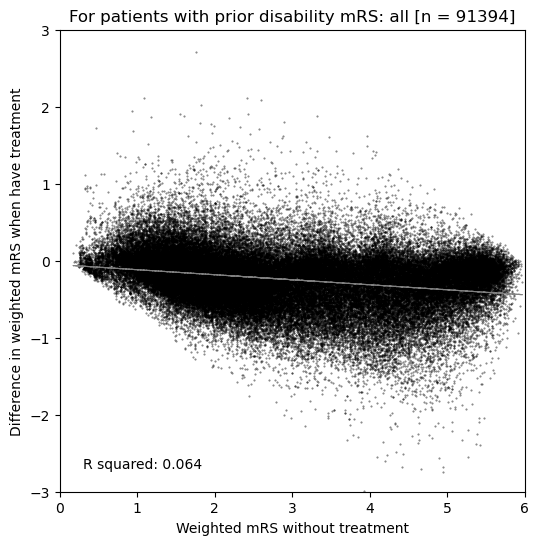

In [41]:
weighted_mrs_all_treated = df_weighted_mrs_per_scenario["All_treated"]
weighted_mrs_none_treated = df_weighted_mrs_per_scenario["None_treated"]

x = weighted_mrs_none_treated.values.reshape(-1, 1)

predicted_mrs_shift_due_to_thrombolysis = (
                        weighted_mrs_all_treated - weighted_mrs_none_treated)
y = predicted_mrs_shift_due_to_thrombolysis.values.reshape(-1, 1)

x_min = round(x.min(),0)
x_max = round(x.max(),0)
y_min = round(y.min(),0)
y_max = round(y.max(),0)

# The full dataset
(slr, r_square) = fit_logstic_regression(x, y)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

n_patients = x.shape[0]
title = f"all [n = {n_patients}]"

ax1.scatter(x, y, s=0.2, c="k", alpha=0.3)

plt.plot (x, slr.predict(x), color = 'grey', linewidth=0.8, linestyle="--")

x_range = x_max - x_min
text = f'R squared: {r_square:.3f}'
ax1.text((x_min + x_range/20), y_min*0.9, text, 
            bbox=dict(facecolor='white', edgecolor='white'))

plot_scatter(x, y, slr, r_square, ax1, x_min, x_max, y_min, y_max, 
             "Weighted mRS without treatment", 
             "Difference in weighted mRS when have treatment", title)

Per prior disabiliy

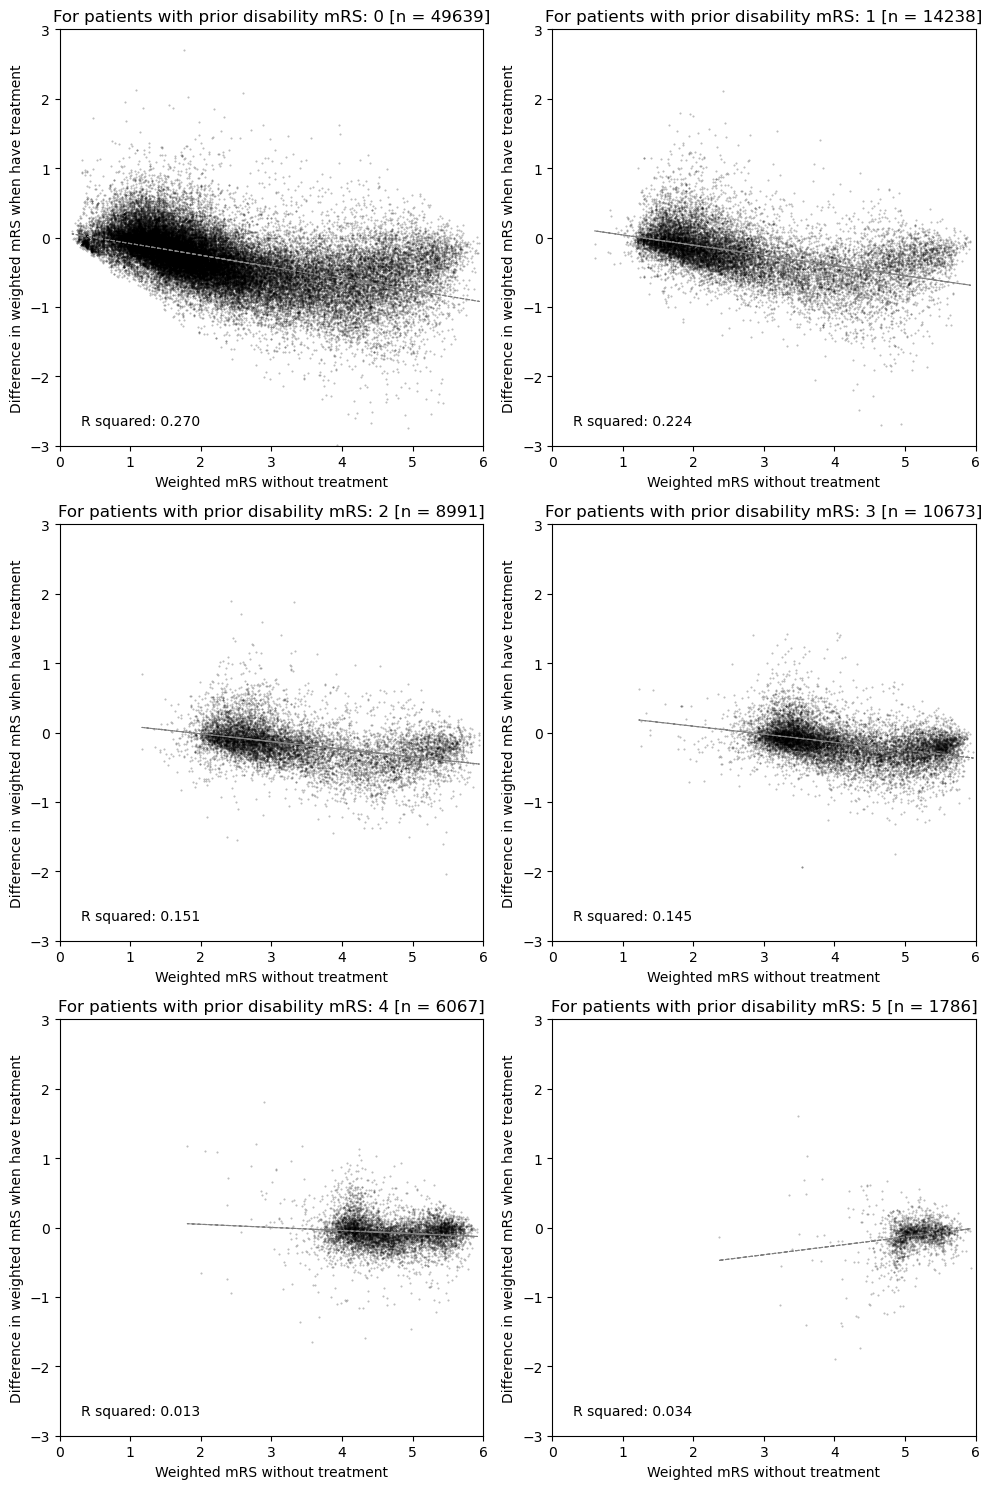

In [42]:
fig = plt.figure(figsize=(10,15))

for subplot, prior_disability in enumerate(list(set(data["prior_disability"]))):
    mask = (data["prior_disability"] == prior_disability).values
    x = weighted_mrs_none_treated[mask].values.reshape(-1, 1)
    y = predicted_mrs_shift_due_to_thrombolysis[mask].values.reshape(-1, 1)

    # The full dataset
    (slr, r_square) = fit_logstic_regression(x, y)

    ax1 = fig.add_subplot(3,2,subplot+1)

    n_patients = x.shape[0]
    title = f"{prior_disability} [n = {n_patients}]"
    plot_scatter(x, y, slr, r_square, ax1, x_min, x_max, y_min, y_max, 
                 "Weighted mRS without treatment", 
                 "Difference in weighted mRS when have treatment", 
                 title)
    
fig.tight_layout()